On montre comment utiliser la méthode de Zouteindijk pour résoudre le programme non linéaire suivant

\begin{equation*}
\begin{array}{l}
\text{Minimiser }   3x_1^2+2x_1x_2+2x_2^2-6x_1-9x_2\\[1mm]
-3x_1+6x_2\leqslant 9   \\
-2x_1+\phantom{6}x_2\leqslant 1   \\
x_1,x_2\geqslant 0.
\end{array}
\end{equation*}

In [1]:
using Plots, JuMP, Optim, GLPK, Ipopt, MathOptInterface

On commence par résoudre le problème graphiquement. 

On dessine les contours de la fonction $f$ ainsi que l'ensemble des points admissibles. Ça nous permet d'avoir une idée sur  l'existence et l'estimation de la solution.

In [4]:
function f(x)
	return 3x[1]^2+2x[1]*x[2]+2x[2]^2-6x[1]-9x[2]
end
	
function df(x)
	return [6x[1]+2x[2]-6, 4x[2]+2x[1]-9]
end
	
function g1(x,y)
	return -3x+6y
end
	
function g2(x,y)
	return -2x+y
end

g2 (generic function with 1 method)

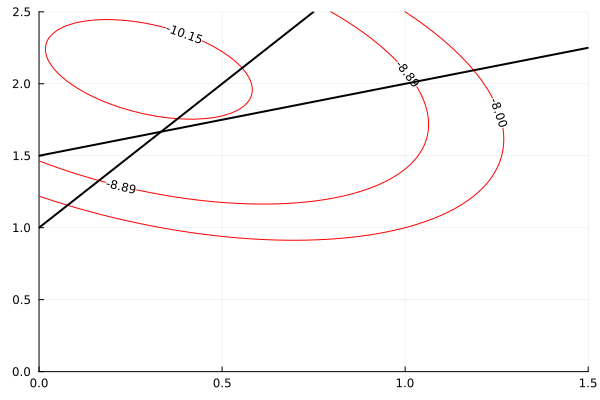

In [7]:
nx = 200
ny = 199
xx = range(0,5, length=nx)
yy = range(0,5, length=ny)
ff = zeros(nx, ny)

for i in 1:nx
    for j in 1:ny
        ff[i,j] = f([xx[i], yy[j]])
    end
end


contour(xx, yy, ff', levels = [-10.15,-8.89, -8], color="red", colorbar = false, contour_labels=true, xlims=(0,1.5), ylims=(0, 2.5))
contour!(xx,yy,g1, levels=[9], color="black", linewidth=2 )
contour!(xx,yy, g2, levels=[1], color="black", linewidth=2)

Résolution du problème en utilisant le module `JuMP` avec le solveur `Ipopt`.

In [8]:
modele = Model(Ipopt.Optimizer)
set_silent(modele)

# définition des variables
@variable(modele, x[1:2] >= 0)

# définition de la fonction objectif
@NLobjective(modele, Min, 3x[1]^2+2x[1]*x[2]+2x[2]^2-6x[1]-9x[2])

# définition des contraintes
@constraint(modele, -3x[1]+6x[2] <= 9)
@constraint(modele, -2x[1]+x[2] <= 1)

# résolution du problème
optimize!(modele);

#affichage de la valeur optimale
@show objective_value(modele)

#affichage de la solution
println("solution = $(value.(x))")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

objective_value(modele) = -10.125000012513723
solution = [0.49999999678061535, 1.7500000109040321]


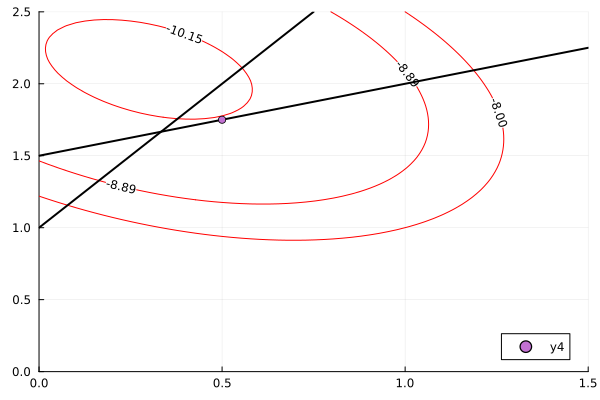

In [9]:
# affichage de la solution optimale
scatter!([value.(x)[1]], [value.(x)[2]])

In [10]:
x0 = [0.0,0]
A = [-3 6; -2 1; -1 0; 0 -1]
b = [9, 1, 0, 0];
liste_iteres = [x0]
n = length(x0)

2

In [17]:
linearModel = Model(GLPK.Optimizer)
@variable(linearModel, -1 .<= d[1:n] .<= 1)
set_objective_sense(linearModel, MathOptInterface.MIN_SENSE)
ρ = 10^-2

0.010000000000000002

In [39]:
ind = findall(abs.(A*x0-b) .<= ρ)
println("ind = $ind")
A1 = A[ind, :]
b1 = b[ind]
A2 = A[setdiff(1:4, ind),:]
b2 = b[setdiff(1:4,ind)];

ind = [2]


In [40]:
set_objective_function(linearModel, df(x0)'*d)
@constraint(linearModel, cons, A1*d .<= b1)
optimize!(linearModel)
print(linearModel)

In [41]:
hd = A2*value.(d)
hb = (b2-A2*x0)[hd .> 0]
hd = hd[hd .> 0]
α_max = hb != [] ? minimum(hb ./ hd) : 100

-0.14285711525366315

In [42]:
# recherche linéaire
ϕ(t) = f(x0+t*value.(d))
res = Optim.optimize(ϕ, 0, α_max, GoldenSection())
α = Optim.minimizer(res)

LoadError: x_lower must be less than x_upper

In [36]:
x0 = x0+α*value.(d) 
println(df(x0)'*value.(d))
append!(liste_iteres, [x0])

-1.0000000052891913


4-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [1.0714285589491293, 1.0714285589491293]
 [0.4285714238328525, 1.7142856940654059]
 [0.38095237351428474, 1.7619047443839737]

In [37]:
unregister(linearModel,:cons)
delete(linearModel, cons)

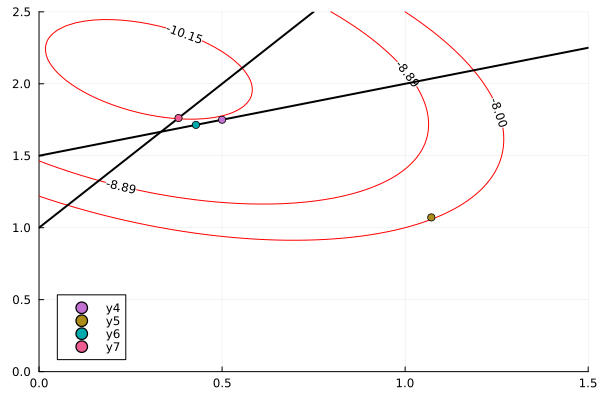

In [38]:
scatter!([x0[1]], [x0[2]])

In [ ]:


function zouteindijk_linear(f, df, A, b, Q, c, x0, ϵ, itermax=20)
   
    ρ = 0.01
    i = 1
    x = deepcopy(x0)
    n = length(x0)
    liste_iteres = [x]
    mon_modele = Model(GLPK.Optimizer)
    @variable(mon_modele, -1 .<= d[1:n] .<= 1)
    if Q != []
        @constraint(mon_modele, Q*d .== 0)
    end
    
    while i< itermax
        # Déterminer les contraintes actives
        ind = findall(abs.(A*x-b) .<= ρ)
        println("ind = $ind")
        A1 = A[ind, :]
        b1 = b[ind]
        A2 = A[setdiff(1:4, ind),:]
        b2 = b[setdiff(1:4,ind)];
        
        set_objective_function(mon_modele, df(x)'*d)
        @constraint(mon_modele, cons, A1*d .<= 0)
        optimize!(mon_modele)
        
        # Calcul de alphamax
        hd = A2*value.(d)
        hb = (b2-A2*x)[hd .> 0]
        hd = hd[hd .> 0]
        α_max = hb != [] ? minimum(hb ./ hd) : 100
        
        # Calcul de alpha
        ϕ(t) = f(x0+t*value.(d))
        res = Optim.optimize(ϕ, 0, α_max, GoldenSection())
        α = Optim.minimizer(res)
        
        # mise à jour de la solution
        x = x+α*value.(d)
        append!(liste_iteres, [x])
        
        if abs(df(x0)'*value.(d))<ϵ 
            return x0, f(x0), liste_iteres
        end
        
        unregister(mon_modele,:cons)
        delete(mon_modele, cons)
        i += 1
    end
    
end